# Autoregressive Models

In this practical, we'll go over the following topics:
- Autoregressive models and when to use them
- Implementing equivariances in Autoregressive GNNs
- Evaluating scientific AI models

But first, a short introduction on the dataset used for this practical.

![Boids gif](figures/boids.gif)

## Boids (by Craig Reynolds)

The Boids algorithm, developed by Craig Reynolds [2], aims to replicate the behavior of flocking birds. 

The simplest setting, used in this practical, follows three simple rules:

1. Separation: Each boid should steer away from crowding local flockmates (avoiding collisions)
2. Alignment: Each boid should steer towards the average heading of local flockmates
3. Cohesion: Each boid should steer towards the average position of local flockmates

With some parameter tuning, these rules allow for some surprisingly realistic behavior. A gif of one of the simulations is shown above.

### Implementation details

Our dataset consists of 1000 samples of Boids simulations. Each simulation has 25 Boids and continues for 1000 timesteps. The Boids fly around in a 2D grid of 1000 x 1000 units.

In our simulations, **Boids steer away from eachother (Separation) if they are within 16 units of eachother**. Boids **steer towards the average heading/position of all (local) flockmates within 40 units**.*
Finally, we use periodic boundary conditions; Boids cannot leave the screen, they re-enter on the other side (pacman style).

* We use Euclidean distance (with PBC) here to compute the distance between boids. For a more detailed explanation, visit [The minimum image convention](https://en.wikibooks.org/wiki/Molecular_Simulation/Periodic_Boundary_Conditions) section of the wikibooks page on PBC.

## Problem setting

Boids simulations feature complex interactions between multiple actors (nodes). The simulation can be chaotic and very sensitive to initial conditions. 


This makes it an interesting playground for the models/frameworks discussed in the course. In this practical, we will implement an AR model from scratch, then gradually introduce equivariances and training/evaluation methods.


In [1]:
import torch 

import torch_geometric
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.loader import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import os

## Data exploration

First let's look at the data structure, and some statistics.

In [2]:
trajectories = [np.load(f"../data/boids/raw/{f}") for f in os.listdir("../data/boids/raw") if f.endswith(".npy")]
print(len(trajectories))

26


In [3]:
print("Single trajectory shape:")
print(trajectories[0].shape)
print("The axes and their cardinalities; (Timesteps:1000, Boids:25, (Position X, Position Y, Velocity x, Velocity y):4)")

Single trajectory shape:
(1000, 25, 4)
The axes and their cardinalities; (Timesteps:1000, Boids:25, (Position X, Position Y, Velocity x, Velocity y):4)


In [4]:
# Print the mean, std, min and max of the boid positions, velocities
positions = np.array([t[:, :, :2] for t in trajectories])
velocities = np.array([t[:, :, 2:] for t in trajectories])

print("Position mean, std, min, max:")
# Round to 2 decimal places
print(round(np.mean(positions),2), round(np.std(positions),2), round(np.min(positions), 2), round(np.max(positions), 2))
print()
print("Velocity mean, std, min, max:")
# Round to 2 decimal places
print(round(np.mean(velocities),2), round(np.std(velocities),2), round(np.min(velocities), 2), round(np.max(velocities), 2))

Position mean, std, min, max:
500.32 290.61 0.0 1000.0

Velocity mean, std, min, max:
-0.35 2.96 -6.0 6.0


In [5]:
def plot_state(trajectory, timestep):
    fig, ax = plt.subplots()
    # Plot dots for the boids
    ax.scatter(trajectory[timestep, :, 0], trajectory[timestep, :, 1])
    # plot the boid velocities as arrows
    for i in range(trajectory.shape[1]):
        # NOTE: The arrows are made larger for effect
        ax.arrow(trajectory[timestep, i, 0], trajectory[timestep, i, 1], trajectory[timestep, i, 2]*5, trajectory[timestep, i, 3]*5)
    return ax

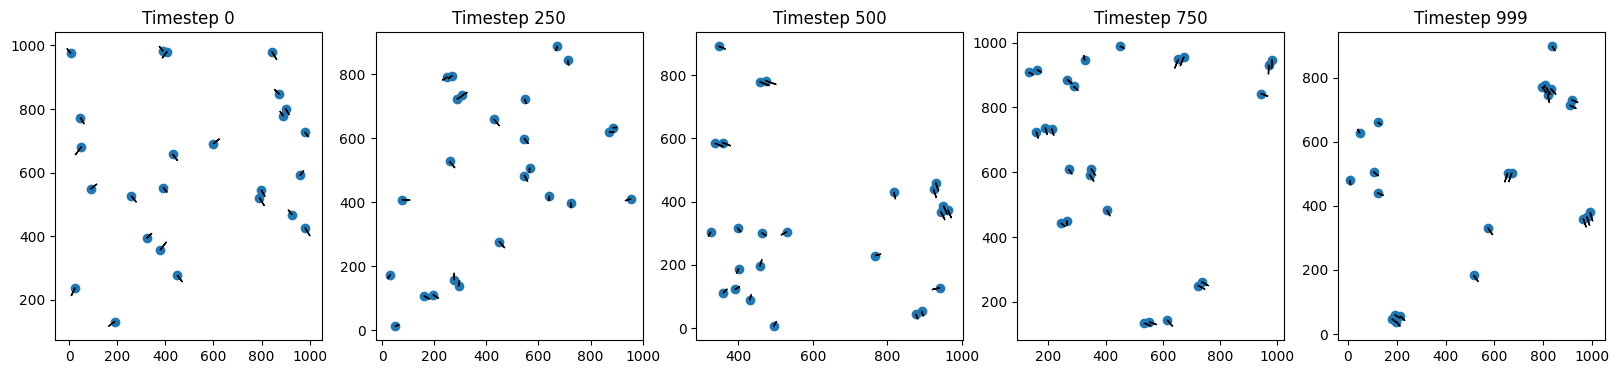

In [6]:
# Plot timesteps 0, 250, 500, 750, 999 for the first trajectory
trajectory = trajectories[0]
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, t in enumerate([0, 250, 500, 750, 999]):
    axs[i].set_title(f"Timestep {t}")
    # Plot dots for the boids
    axs[i].scatter(trajectory[t, :, 0], trajectory[t, :, 1])
    # plot the boid velocities as arrows
    for j in range(trajectory.shape[1]):
        # NOTE: The arrows are made larger for effect
        axs[i].arrow(trajectory[t, j, 0], trajectory[t, j, 1], trajectory[t, j, 2]*5, trajectory[t, j, 3]*5)
plt.show()

In the plot above, you can see that after some warmup time, the boids start to form flocks. Flocking behavior is a form of inter-node communication, which we will come back to again later.

Thinking back to the Geometric Deep Learning framework, we can identify the following symmetries in the data:

- The boids are equivariant to permutations, ie it does not matter in which order we compute the update rules for the boids.
- **Local flocks of boids are equivariant to translation, rotation and reflection.** 

Following these symmetries, it makes sense to model the boids using a Graph Neural Network (GNN). Specifically, since we are dealing with inter-node communication, we will be implementing a Message Passing GNN here.

But first, we create a `torch_geometric` InMemoryDataset object, to model the data as a graph.

In [7]:
class AR_Boids_Dataset(InMemoryDataset):
    def __init__(self, raw_data_path, processed_data_path, root=None, transform=None, pre_transform=None, post_transform=None, solution_idx_range=(0, 25), timesteps=1000, processed_file_name="AR1_Boids.pt"):
        self.raw_data_path = raw_data_path
        self.processed_data_path = processed_data_path
        self.solution_idx_range = solution_idx_range
        self.timesteps = timesteps
        self.processed_file_name = processed_file_name
        self.pre_transform = pre_transform
        self.transform = transform
        self.post_transform = post_transform
        super(AR_Boids_Dataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)

    @property
    def processed_file_names(self):
        return [self.processed_file_name]

    @property
    def raw_file_names(self):
        return [pfn for pfn in os.listdir(self.raw_data_path) if (self.solution_idx_range[0] <= int(pfn.split("_")[-1][:-4]) < self.solution_idx_range[1])]
    
    def download(self):
        pass
    
    def __len__(self):
        return (self.timesteps - 1) * (self.solution_idx_range[1] - self.solution_idx_range[0])

    def process(self):
        data_list = []
        for idx, raw_path in enumerate(self.raw_file_names):
            trajectory = np.load(self.raw_data_path + raw_path)

            if self.transform is not None:
                trajectory = self.transform(trajectory)

            for t in range(trajectory.shape[0] - 1):
                x = torch.tensor(trajectory[t], dtype=torch.float)
                y_temp = torch.tensor(trajectory[t+1], dtype=torch.float)
                # Right now y is (position x, position y, velocity x, velocity y) for the next timestep
                # However, we want delta position and delta velocity
                # Luckily, the delta poisition is just the velocity from the next timestep, and the delta velocity is the acceleration
                # So we can just take the last two elements of y to get the delta velocity
                # First we copy the last two columns of y to the first two columns of y
                y = y_temp.clone()
                y[:, :2] = y_temp[:, 2:]
                # Then we calculate the acceleration
                y[:, 2:] = y_temp[:, 2:] - x[:, 2:]

                edge_index = torch.tensor([[i, j] for i in range(trajectory.shape[1]) for j in range(trajectory.shape[1]) if i != j], dtype=torch.long).t().contiguous()
    
                if self.post_transform is not None:
                    data = self.post_transform(data)
                
                data = Data(x=x, y=y, edge_index=edge_index)
                data_list.append(data)
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_data_path+self.processed_file_name)

    def __getitem__(self, idx):
        return self.get(idx)
    
    def __repr__(self):
        return f'{self.__class__.__name__}({len(self)})'

In [8]:
train_dataset = AR_Boids_Dataset(raw_data_path="../data/boids/raw/", processed_data_path="../data/boids/processed/", root="../data/boids/", solution_idx_range=(0, 15), timesteps=1000, processed_file_name="AR1_Boids.pt")
validation_dataset = AR_Boids_Dataset(raw_data_path="../data/boids/raw/", processed_data_path="../data/boids/processed/", root="../data/boids/", solution_idx_range=(16, 25), timesteps=1000, processed_file_name="AR1_VAL_Boids.pt")

print(train_dataset)
print(validation_dataset)


data_0 = train_dataset[0]
print(data_0)
print(data_0.keys)
print("Pos x, Pos y, Vel x, Vel y")
print(data_0.x[0,:])

AR_Boids_Dataset(14985)
AR_Boids_Dataset(8991)
Data(x=[25, 4], edge_index=[2, 600], y=[25, 4])
<bound method BaseData.keys of Data(x=[25, 4], edge_index=[2, 600], y=[25, 4])>
Pos x, Pos y, Vel x, Vel y
tensor([ 47., 773.,   3.,  -4.])


/Users/pelokbal/Uni/Q5/2AMM40/Practicals/atai-2024/venv/lib/python3.11/site-packages/torch_geometric/data/dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

## Autoregressive Models
In general, when dealing with simulations spanning multiple timesteps, we can define the learning problem as follows.

Let $X^{0:T-1}$ denote the states spanning across timesteps $t=0$ through $t=T-1$. Given the initial state $X^0$, our goal is to accurately predict the future states $X^{1:T-1}$. In the probabilistic case, we want to learn a model with parameters $\theta$ for the probability distribution $P_\theta(X^{1:T-1}|X^0)$.*

In some systems, such as in the Boids setting, the next state $X^{t+1}$ is only dependent on the current state $X^t$. Such systems are memoryless, and are often said to be _Markovian_. The Markov property allows us to rewrite the learning task to $P_\theta(X^{1:T-1}|X^0) = P(X^0) \cdot \prod_{t=1}^{T-1} P_\theta(X^{t+1} | X^t)$

Here, $P_\theta(X^{t+1} | X^t)$ is the _Autoregressive model_ - literally meaning it is used to autoregressively construct the full trajectory of the system. Note that this model is autoregressive in time; not space.

*: In this practical, we will not be building a probabilistic model. So instead of parameterizing a distribution, we learn a function $f_\theta: X^t \rarr X^{t+1}$.

### Autoregressive set model

Below, we create the simplest AR model for the Boids system; a fully connected GNN (essentially a set model).

Given a fully connected graph $X^t$, representing the Boids system at time $t$; it learns to predict the next state of the system $X^t+1$.

Note here that we use all features from the dataset as node features. This causes the model to not be equivariant to some group actions, that are relevant in the Boids setting.

---

Tick the equivariance(s) of this model:

- <input
      type="checkbox"
      id="eq0"
      name="perm"
      value="perm" />
    <label for="eq1">Permutational Equivariance</label>

- <input
      type="checkbox"
      id="eq1"
      name="space"
      value="space" />
    <label for="eq1">Space Translation Equivariance</label>

- <input
      type="checkbox"
      id="eq2"
      name="time"
      value="time" />
    <label for="eq2">Time Translation Equivariance</label>

- <input
      type="checkbox"
      id="eq3"
      name="rot"
      value="rot" />
    <label for="eq3">Rotation/Reflection Equivariance</label>

In [9]:
class AR_Set_Model(torch.nn.Module):
    def __init__(self, node_dim=4, emb_dim=16, out_dim=4):
        super(AR_Set_Model, self).__init__()
        self.node_embedding = torch.nn.Linear(node_dim, emb_dim)
        self.conv1 = torch_geometric.nn.GCNConv(emb_dim, emb_dim)
        self.conv2 = torch_geometric.nn.GCNConv(emb_dim, out_dim)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.node_embedding(x)
        x = torch.nn.functional.relu(x)
        x = self.conv1(x, edge_index)
        x = torch.nn.functional.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [10]:
class Trainer:
    def __init__(self, model, train_dataset, validation_dataset, batch_size=1, lr=0.0001, epochs=100, loss_fn=torch.nn.MSELoss(), model_name= "01-AR-Set-Model.pt"):
        """
        Simple Trainer class to train a PyTorch (geometric) model on a dataset.

        Args:
            model: PyTorch model to train
            train_dataset: PyTorch dataset to train on
            validation_dataset: PyTorch dataset to validate on
            batch_size: Batch size for training
            lr: Learning rate
            epochs: Number of epochs to train for
            loss_fn: Loss function to use
        """
        self.model = model
        self.train_dataset = train_dataset
        self.validation_dataset = validation_dataset
        self.batch_size = batch_size
        self.lr = lr
        self.epochs = epochs
        self.loss_fn = loss_fn
        self.model_name = model_name

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
        print("Using device:", self.device)
        self.model.to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)

        self.train_loader = self.make_data_loader(self.train_dataset)
        self.validation_loader = self.make_data_loader(self.validation_dataset, shuffle=False)

    def make_data_loader(self, dataset, shuffle=True):
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=shuffle)

    def train_loop(self):
        """
        Train loop for the model
        """
        best_model_loss = np.inf
        for epoch in trange(self.epochs, desc="Training"):
            # Train the model
            self.model.train()
            mean_train_loss = 0
            for i, data in enumerate(self.train_loader):
                data = self.train_dataset[i].to(self.device)
                self.optimizer.zero_grad()
                out = self.model(data)
                loss = self.loss_fn(out, data.y)
                loss.backward()
                self.optimizer.step()
                mean_train_loss += loss.item()
            mean_train_loss /= i
            
            # Validate the model
            self.model.eval()
            mean_val_loss = 0
            with torch.no_grad():
                for i, data in enumerate(self.validation_loader):
                    data = self.validation_dataset[i].to(self.device)
                    out = self.model(data)
                    loss = self.loss_fn(out, data.y)
                    mean_val_loss += loss.item()
                mean_val_loss /= i

            if mean_val_loss < best_model_loss:
                best_model_loss = mean_val_loss
                torch.save(self.model.state_dict(), f"../models/{self.model_name}")
            
            print(f"Epoch {epoch}, Mean Train Loss: {mean_train_loss}, Mean Validation Loss: {mean_val_loss}")



In [83]:
model = AR_Set_Model(emb_dim=64)
trainer = Trainer(model, train_dataset, validation_dataset, batch_size=8, loss_fn=torch.nn.MSELoss(), epochs=100, model_name="01-AR-Set-Model.pt")
trainer.train_loop()

Using device: mps


Training:   1%|          | 1/100 [00:21<35:33, 21.55s/it]

Epoch 0, Mean Train Loss: 62.68743697061809, Mean Validation Loss: 66.00681655574672


Training:   2%|▏         | 2/100 [00:44<36:37, 22.43s/it]

Epoch 1, Mean Train Loss: 11.270683203765687, Mean Validation Loss: 47.10630943131893


Training:   3%|▎         | 3/100 [01:08<37:12, 23.02s/it]

Epoch 2, Mean Train Loss: 8.131034035257521, Mean Validation Loss: 32.39689916260839


Training:   4%|▍         | 4/100 [01:31<36:41, 22.93s/it]

Epoch 3, Mean Train Loss: 6.953884056686273, Mean Validation Loss: 25.13199010451564


Training:   5%|▌         | 5/100 [01:54<36:17, 22.92s/it]

Epoch 4, Mean Train Loss: 5.829253169793976, Mean Validation Loss: 19.658308404954756


Training:   6%|▌         | 6/100 [02:17<36:05, 23.04s/it]

Epoch 5, Mean Train Loss: 5.498055240303453, Mean Validation Loss: 18.094902201624503


Training:   7%|▋         | 7/100 [02:39<35:31, 22.92s/it]

Epoch 6, Mean Train Loss: 5.148780495389794, Mean Validation Loss: 14.390815809594661


Training:   8%|▊         | 8/100 [03:02<35:06, 22.90s/it]

Epoch 7, Mean Train Loss: 4.933377255714964, Mean Validation Loss: 13.390648272031138


Training:   9%|▉         | 9/100 [03:26<35:14, 23.23s/it]

Epoch 8, Mean Train Loss: 4.628431120341434, Mean Validation Loss: 12.596495365098663


Training:  10%|█         | 10/100 [03:49<34:47, 23.20s/it]

Epoch 9, Mean Train Loss: 4.375648832041124, Mean Validation Loss: 11.72398607495207


Training:  11%|█         | 11/100 [04:13<34:35, 23.32s/it]

Epoch 10, Mean Train Loss: 4.247070615423979, Mean Validation Loss: 11.35715724481394


Training:  12%|█▏        | 12/100 [04:36<34:15, 23.36s/it]

Epoch 11, Mean Train Loss: 4.229673867389854, Mean Validation Loss: 10.32964723108076


Training:  13%|█▎        | 13/100 [05:00<33:44, 23.27s/it]

Epoch 12, Mean Train Loss: 4.041255397842456, Mean Validation Loss: 10.201819174436194


Training:  14%|█▍        | 14/100 [05:22<33:07, 23.10s/it]

Epoch 13, Mean Train Loss: 4.137043148135986, Mean Validation Loss: 13.22590873799787


Training:  15%|█▌        | 15/100 [05:44<32:01, 22.61s/it]

Epoch 14, Mean Train Loss: 4.031643669998589, Mean Validation Loss: 9.229513861298667


Training:  16%|█▌        | 16/100 [06:07<32:03, 22.90s/it]

Epoch 15, Mean Train Loss: 3.7802053941359066, Mean Validation Loss: 9.03734275282013


Training:  17%|█▋        | 17/100 [06:31<32:10, 23.26s/it]

Epoch 16, Mean Train Loss: 3.7898424402062294, Mean Validation Loss: 11.090131083239642


Training:  18%|█▊        | 18/100 [06:54<31:42, 23.20s/it]

Epoch 17, Mean Train Loss: 3.7437462448055454, Mean Validation Loss: 8.811563968446142


Training:  19%|█▉        | 19/100 [07:18<31:20, 23.21s/it]

Epoch 18, Mean Train Loss: 3.66615073558677, Mean Validation Loss: 8.748580133500953


Training:  20%|██        | 20/100 [07:40<30:47, 23.09s/it]

Epoch 19, Mean Train Loss: 3.629691114033599, Mean Validation Loss: 8.780623810480241


Training:  21%|██        | 21/100 [08:04<30:31, 23.18s/it]

Epoch 20, Mean Train Loss: 3.5952609257779526, Mean Validation Loss: 8.81844583389914


Training:  22%|██▏       | 22/100 [08:27<29:57, 23.04s/it]

Epoch 21, Mean Train Loss: 3.5565035427501352, Mean Validation Loss: 8.733615956132367


Training:  23%|██▎       | 23/100 [08:49<29:22, 22.88s/it]

Epoch 22, Mean Train Loss: 3.5068939769579903, Mean Validation Loss: 8.364559283133394


Training:  24%|██▍       | 24/100 [09:13<29:30, 23.29s/it]

Epoch 23, Mean Train Loss: 3.4568351440676635, Mean Validation Loss: 8.095080081628883


Training:  25%|██▌       | 25/100 [09:37<29:12, 23.37s/it]

Epoch 24, Mean Train Loss: 3.4225974542472177, Mean Validation Loss: 7.950368470415301


Training:  26%|██▌       | 26/100 [10:00<28:35, 23.19s/it]

Epoch 25, Mean Train Loss: 3.40855802782576, Mean Validation Loss: 7.885495375440467


Training:  27%|██▋       | 27/100 [10:22<27:51, 22.90s/it]

Epoch 26, Mean Train Loss: 3.419144624353919, Mean Validation Loss: 7.907965697036294


Training:  28%|██▊       | 28/100 [10:44<27:13, 22.69s/it]

Epoch 27, Mean Train Loss: 3.411925783560865, Mean Validation Loss: 7.7648789199037624


Training:  29%|██▉       | 29/100 [11:06<26:33, 22.45s/it]

Epoch 28, Mean Train Loss: 3.4339558355514215, Mean Validation Loss: 8.0195539914808


Training:  30%|███       | 30/100 [11:27<25:48, 22.12s/it]

Epoch 29, Mean Train Loss: 3.433391605636619, Mean Validation Loss: 8.353028466843751


Training:  31%|███       | 31/100 [11:50<25:27, 22.14s/it]

Epoch 30, Mean Train Loss: 3.4070367637765133, Mean Validation Loss: 8.58294302081807


Training:  32%|███▏      | 32/100 [12:12<25:06, 22.15s/it]

Epoch 31, Mean Train Loss: 3.388854302032326, Mean Validation Loss: 8.39144919689277


Training:  33%|███▎      | 33/100 [12:34<24:41, 22.11s/it]

Epoch 32, Mean Train Loss: 3.3573506646976075, Mean Validation Loss: 8.521824685569756


Training:  34%|███▍      | 34/100 [12:56<24:18, 22.09s/it]

Epoch 33, Mean Train Loss: 3.31600891897784, Mean Validation Loss: 7.718594256194701


Training:  35%|███▌      | 35/100 [13:18<24:01, 22.18s/it]

Epoch 34, Mean Train Loss: 3.321677249125854, Mean Validation Loss: 7.725815722693955


Training:  36%|███▌      | 36/100 [13:41<23:54, 22.41s/it]

Epoch 35, Mean Train Loss: 3.336113876031162, Mean Validation Loss: 8.38833525025834


Training:  37%|███▋      | 37/100 [14:04<23:44, 22.60s/it]

Epoch 36, Mean Train Loss: 3.3378178107821235, Mean Validation Loss: 8.184110670140674


Training:  38%|███▊      | 38/100 [14:29<23:55, 23.16s/it]

Epoch 37, Mean Train Loss: 3.36828442311707, Mean Validation Loss: 7.994592099983779


Training:  39%|███▉      | 39/100 [14:52<23:36, 23.21s/it]

Epoch 38, Mean Train Loss: 3.2565248684964585, Mean Validation Loss: 7.727595143730048


Training:  40%|████      | 40/100 [15:14<23:00, 23.01s/it]

Epoch 39, Mean Train Loss: 3.243092225728287, Mean Validation Loss: 8.308722966076111


Training:  41%|████      | 41/100 [15:37<22:24, 22.79s/it]

Epoch 40, Mean Train Loss: 3.2531489157702156, Mean Validation Loss: 7.8321285848626045


Training:  42%|████▏     | 42/100 [15:59<21:49, 22.57s/it]

Epoch 41, Mean Train Loss: 3.237182046185823, Mean Validation Loss: 7.814767151566775


Training:  43%|████▎     | 43/100 [16:20<21:09, 22.27s/it]

Epoch 42, Mean Train Loss: 3.244301670481035, Mean Validation Loss: 7.508643414012471


Training:  44%|████▍     | 44/100 [16:42<20:42, 22.18s/it]

Epoch 43, Mean Train Loss: 3.2382900777883985, Mean Validation Loss: 8.037202975628956


Training:  45%|████▌     | 45/100 [17:04<20:18, 22.15s/it]

Epoch 44, Mean Train Loss: 3.215453466310007, Mean Validation Loss: 8.077084232416942


Training:  46%|████▌     | 46/100 [17:27<19:55, 22.13s/it]

Epoch 45, Mean Train Loss: 3.2124179159964843, Mean Validation Loss: 7.98694600893362


Training:  47%|████▋     | 47/100 [17:48<19:28, 22.05s/it]

Epoch 46, Mean Train Loss: 3.2603370351264394, Mean Validation Loss: 8.197770554787967


Training:  48%|████▊     | 48/100 [18:10<19:04, 22.01s/it]

Epoch 47, Mean Train Loss: 3.2740831984852448, Mean Validation Loss: 8.159754799395296


Training:  49%|████▉     | 49/100 [18:32<18:36, 21.88s/it]

Epoch 48, Mean Train Loss: 3.2648740118668798, Mean Validation Loss: 8.240798105433491


Training:  50%|█████     | 50/100 [18:52<17:42, 21.25s/it]

Epoch 49, Mean Train Loss: 3.278814004311508, Mean Validation Loss: 8.188600132960033


Training:  51%|█████     | 51/100 [19:13<17:23, 21.30s/it]

Epoch 50, Mean Train Loss: 3.279147636744025, Mean Validation Loss: 8.70740633252892


Training:  52%|█████▏    | 52/100 [19:35<17:11, 21.49s/it]

Epoch 51, Mean Train Loss: 3.287021956848576, Mean Validation Loss: 8.425564314994235


Training:  53%|█████▎    | 53/100 [19:55<16:30, 21.07s/it]

Epoch 52, Mean Train Loss: 3.2481431301048715, Mean Validation Loss: 8.410849924291337


Training:  54%|█████▍    | 54/100 [20:17<16:18, 21.28s/it]

Epoch 53, Mean Train Loss: 3.3329404555917486, Mean Validation Loss: 11.936006371930361


Training:  55%|█████▌    | 55/100 [20:36<15:34, 20.77s/it]

Epoch 54, Mean Train Loss: 3.5866889674843025, Mean Validation Loss: 13.312271243636351


Training:  56%|█████▌    | 56/100 [20:59<15:36, 21.29s/it]

Epoch 55, Mean Train Loss: 3.495562463919237, Mean Validation Loss: 12.271098613526709


Training:  57%|█████▋    | 57/100 [21:19<14:59, 20.91s/it]

Epoch 56, Mean Train Loss: 3.377532132729705, Mean Validation Loss: 10.64005576661943


Training:  58%|█████▊    | 58/100 [21:40<14:34, 20.83s/it]

Epoch 57, Mean Train Loss: 3.2876947034633677, Mean Validation Loss: 10.018096058897322


Training:  59%|█████▉    | 59/100 [22:00<14:07, 20.68s/it]

Epoch 58, Mean Train Loss: 3.2480546335008014, Mean Validation Loss: 9.61439413060488


Training:  60%|██████    | 60/100 [22:22<14:06, 21.17s/it]

Epoch 59, Mean Train Loss: 3.203629465677238, Mean Validation Loss: 9.222564170749083


Training:  61%|██████    | 61/100 [22:42<13:28, 20.72s/it]

Epoch 60, Mean Train Loss: 3.2224794253905826, Mean Validation Loss: 8.624571682190322


Training:  62%|██████▏   | 62/100 [23:03<13:12, 20.86s/it]

Epoch 61, Mean Train Loss: 3.2425377998387694, Mean Validation Loss: 8.213263570253911


Training:  63%|██████▎   | 63/100 [23:24<12:50, 20.82s/it]

Epoch 62, Mean Train Loss: 3.3009288597412434, Mean Validation Loss: 8.553825248062664


Training:  64%|██████▍   | 64/100 [23:45<12:28, 20.80s/it]

Epoch 63, Mean Train Loss: 3.2548891975163015, Mean Validation Loss: 7.932206366174686


Training:  65%|██████▌   | 65/100 [24:06<12:12, 20.94s/it]

Epoch 64, Mean Train Loss: 3.1299241619891682, Mean Validation Loss: 8.174918736715139


Training:  66%|██████▌   | 66/100 [24:27<11:54, 21.01s/it]

Epoch 65, Mean Train Loss: 3.107520995232999, Mean Validation Loss: 7.654360267591604


Training:  67%|██████▋   | 67/100 [24:48<11:29, 20.88s/it]

Epoch 66, Mean Train Loss: 3.081820575266806, Mean Validation Loss: 7.030415028625583


Training:  68%|██████▊   | 68/100 [25:09<11:12, 21.01s/it]

Epoch 67, Mean Train Loss: 3.0639865179782366, Mean Validation Loss: 7.0981595072487265


Training:  69%|██████▉   | 69/100 [25:29<10:46, 20.86s/it]

Epoch 68, Mean Train Loss: 3.0592357161779553, Mean Validation Loss: 7.364624250816216


Training:  70%|███████   | 70/100 [25:49<10:14, 20.49s/it]

Epoch 69, Mean Train Loss: 3.01532857639549, Mean Validation Loss: 7.449654687438176


Training:  71%|███████   | 71/100 [26:09<09:46, 20.24s/it]

Epoch 70, Mean Train Loss: 2.9909149811220757, Mean Validation Loss: 7.234871374318776


Training:  72%|███████▏  | 72/100 [26:31<09:46, 20.94s/it]

Epoch 71, Mean Train Loss: 2.960366497941025, Mean Validation Loss: 7.345232684168557


Training:  73%|███████▎  | 73/100 [26:53<09:31, 21.15s/it]

Epoch 72, Mean Train Loss: 2.947149722861276, Mean Validation Loss: 7.431579310874905


Training:  74%|███████▍  | 74/100 [27:14<09:10, 21.19s/it]

Epoch 73, Mean Train Loss: 2.943479198188751, Mean Validation Loss: 7.273104715219907


Training:  75%|███████▌  | 75/100 [27:36<08:55, 21.42s/it]

Epoch 74, Mean Train Loss: 2.947411997268624, Mean Validation Loss: 7.193535814089958


Training:  76%|███████▌  | 76/100 [27:59<08:46, 21.95s/it]

Epoch 75, Mean Train Loss: 2.9414908946101446, Mean Validation Loss: 7.219989955372186


Training:  77%|███████▋  | 77/100 [28:22<08:30, 22.19s/it]

Epoch 76, Mean Train Loss: 2.936159179927319, Mean Validation Loss: 7.239927065977536


Training:  78%|███████▊  | 78/100 [28:41<07:47, 21.24s/it]

Epoch 77, Mean Train Loss: 2.9364346178597582, Mean Validation Loss: 7.254006169252064


Training:  79%|███████▉  | 79/100 [29:00<07:12, 20.59s/it]

Epoch 78, Mean Train Loss: 2.9278152514382345, Mean Validation Loss: 7.303894628930707


Training:  80%|████████  | 80/100 [29:19<06:43, 20.16s/it]

Epoch 79, Mean Train Loss: 2.9364040831289886, Mean Validation Loss: 8.177280769110363


Training:  81%|████████  | 81/100 [29:38<06:16, 19.81s/it]

Epoch 80, Mean Train Loss: 2.972205185820187, Mean Validation Loss: 8.224169006755282


Training:  82%|████████▏ | 82/100 [29:58<05:53, 19.63s/it]

Epoch 81, Mean Train Loss: 2.9942996357127556, Mean Validation Loss: 8.38659492647234


Training:  83%|████████▎ | 83/100 [30:19<05:40, 20.04s/it]

Epoch 82, Mean Train Loss: 3.030109226799113, Mean Validation Loss: 9.192277045942053


Training:  84%|████████▍ | 84/100 [30:42<05:35, 21.00s/it]

Epoch 83, Mean Train Loss: 3.0659003362131196, Mean Validation Loss: 9.335521634094224


Training:  85%|████████▌ | 85/100 [31:04<05:21, 21.42s/it]

Epoch 84, Mean Train Loss: 3.100738328692115, Mean Validation Loss: 9.815309902863744


Training:  86%|████████▌ | 86/100 [31:27<05:06, 21.91s/it]

Epoch 85, Mean Train Loss: 3.1210445987624533, Mean Validation Loss: 10.058480182505036


Training:  87%|████████▋ | 87/100 [31:49<04:44, 21.85s/it]

Epoch 86, Mean Train Loss: 3.118115865477762, Mean Validation Loss: 10.010009978354667


Training:  88%|████████▊ | 88/100 [32:11<04:21, 21.81s/it]

Epoch 87, Mean Train Loss: 3.1067857874375386, Mean Validation Loss: 10.14664096611478


Training:  89%|████████▉ | 89/100 [32:32<03:59, 21.79s/it]

Epoch 88, Mean Train Loss: 3.092737286471455, Mean Validation Loss: 9.873170195364676


Training:  90%|█████████ | 90/100 [32:54<03:37, 21.75s/it]

Epoch 89, Mean Train Loss: 3.068468022270121, Mean Validation Loss: 9.551049849441407


Training:  91%|█████████ | 91/100 [33:16<03:15, 21.75s/it]

Epoch 90, Mean Train Loss: 3.0494592550662643, Mean Validation Loss: 9.303747702366735


Training:  92%|█████████▏| 92/100 [33:37<02:53, 21.71s/it]

Epoch 91, Mean Train Loss: 3.03529717867475, Mean Validation Loss: 9.144880479929814


Training:  93%|█████████▎| 93/100 [33:59<02:32, 21.74s/it]

Epoch 92, Mean Train Loss: 3.0264657541703746, Mean Validation Loss: 8.94422966990212


Training:  94%|█████████▍| 94/100 [34:21<02:10, 21.73s/it]

Epoch 93, Mean Train Loss: 3.01851555009736, Mean Validation Loss: 8.767108679030054


Training:  95%|█████████▌| 95/100 [34:43<01:48, 21.70s/it]

Epoch 94, Mean Train Loss: 3.0085392295518663, Mean Validation Loss: 8.590430639730641


Training:  96%|█████████▌| 96/100 [35:04<01:26, 21.69s/it]

Epoch 95, Mean Train Loss: 3.000109954085251, Mean Validation Loss: 8.443620721251436


Training:  97%|█████████▋| 97/100 [35:26<01:04, 21.66s/it]

Epoch 96, Mean Train Loss: 2.9992533213813486, Mean Validation Loss: 8.35002364203639


Training:  98%|█████████▊| 98/100 [35:48<00:43, 21.67s/it]

Epoch 97, Mean Train Loss: 3.0008755170974384, Mean Validation Loss: 8.177149299203766


Training:  99%|█████████▉| 99/100 [36:10<00:21, 21.78s/it]

Epoch 98, Mean Train Loss: 2.984813782186096, Mean Validation Loss: 7.568968371207015


Training: 100%|██████████| 100/100 [36:32<00:00, 21.92s/it]

Epoch 99, Mean Train Loss: 2.9539088166721097, Mean Validation Loss: 7.4803141749340405


### Q1: Implementing rollout code

We have a working model now to predict $\hat{X}^{t+1}$ given $X^t$. However, we of course want to be able to generate trajectories longer than one step (ie for i steps: $\hat{X}^{t+1:t+i}$), given $X^t$.

We sometimes call this a `rollout` - essentially a multi-step prediction.

Q1: Complete the method below, which generates a rollout of `timesteps` steps, for a given model `model`, and dataset `dataset` *.

HINT: What should happen if the position $x_i, y_i$ of boid $i$ are predicted to move $dx_i, dy_i$, such that $x_i + dx_i > \text{width}$ or $y_i + dy_i > \text{height}$?

*: If you check the cell below the next cell, we already made a dataset for you that only contains initial positions :)

In [18]:
def compute_ar_set_model_rollouts(model, dataset, timesteps=1000, device='cuda', mode="residual", width = 1000, height = 1000, batch_size = 8):
    """
    Predict the rollouts of the model on the dataset starting from the idx

    Args:
        model: PyTorch model
        dataset: PyTorch dataset
        timesteps: Number of timesteps to predict
        device: Device to run the model on
        mode: "residual" or "direct"
        - In the solution above, we used the "residual" mode, where the model predicts the change in position and velocity
        - In the "direct" mode, the model predicts the position and velocity directly (if you do not intend to use this mode, you can ignore this argument)
        width: Width of the PBC box
        height: Height of the PBC box
    Returns:
        rollouts: Rollouts of the model on the dataset
        - Should be a torch tensor of shape (Batch, Timesteps, Boids, Node_dim)
    """
    rollouts = torch.empty((len(dataset), timesteps, dataset[0].x.shape[0], dataset[0].x.shape[1]), device=device)
    print(rollouts.shape)

    # ~ ^ ~ ^ ~ ^ ~ ^ ~ ^ ~ ^
    #     Your code here
    # ~ ^ ~ ^ ~ ^ ~ ^ ~ ^ ~ ^
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    batch_start = 0
    for data in loader:
        batch_end = batch_start + batch_size
        inp = data
        for t in range(timesteps):
            batch_preds = model(inp)
            inp.x = inp.x + batch_preds
            inp.x[:, :2] = inp.x[:, :2] % 1000
            rollouts[batch_start:batch_end, t] = inp.x.view(-1, *rollouts.shape[2:])
            
    return rollouts

In [19]:
def keep_01(data):
    return data[0:2, :, :]

initial_states_validation_dataset = AR_Boids_Dataset(
    raw_data_path="../data/boids/raw/", 
    processed_data_path="../data/boids/processed/", 
    root="../data/boids/", 
    solution_idx_range=(16, 25), 
    timesteps=2, 
    processed_file_name="AR1_VAL_init.pt",
    transform=keep_01
    )

ar_set_model = AR_Set_Model(emb_dim=64)
ar_set_model.load_state_dict(torch.load("../models/01-AR-Set-Model.pt"))
device = 'cuda' if torch.cuda.is_available() else 'cpu'
ar_set_model.to(device)
ar_set_model.eval()

ar_set_model_rollout = compute_ar_set_model_rollouts(ar_set_model, initial_states_validation_dataset, timesteps=1000, device=device)

/Users/pelokbal/Uni/Q5/2AMM40/Practicals/atai-2024/venv/lib/python3.11/site-packages/torch_geometric/data/dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

torch.Size([9, 1000, 25, 4])


We'll evaluate these rollouts later.

### Quick recap on equivariances

<img src="figures/boids-translational-equivariance.png" alt="drawing" width="250" style="background-color: white; padding: 50px;"/>
<img src="figures/boids-rotational-equivariance.png" alt="drawing" width="250" style="background-color: white; padding: 50px;"/>

The figures above show the equivariances of the Boids system. The system is equivariant to all E(n) transformations; translation,
rotation and reflection.*

Formally, we say a function $f: X \rarr Y$ is _equivariant_ to a group action or transformation $T: X \rarr X$ if there is an equivalent transformation $S: Y \rarr Y$ on the output space of the function such that

$f(T(x)) = S(f(x))$ for each $x \in X$

We won't go into the formal definitions of each equivariance, but if you're interested you can check out the [E(n) Equivariant Graph Neural Networks](https://arxiv.org/pdf/2102.09844) paper [3], the equivariant model is based on. 

*: Excluding time translation equivariance, which states that there is no dependence on the time of the system, only the state.

*: Also excluding permutational equivariance; the order of the nodes does not matter.

## Towards Equivariant AR-GNNs
The above model is **not** equivariant to translations in space! This is because we use absolute coordinates as _node features_, which creates a dependence on the absolute coordinate system. Instead, if we do not use the absolute positions as node features - and include the PBC distance as _edge features_ - the predictions will be space translation equivariant.

Let's implement this!

Before, we were not using the fact that boids only affect eachother within a certain radius, since we used a fully connected graph without edge weights.

Before blindly jumping into the new dataset code, let's investigate this behavior.

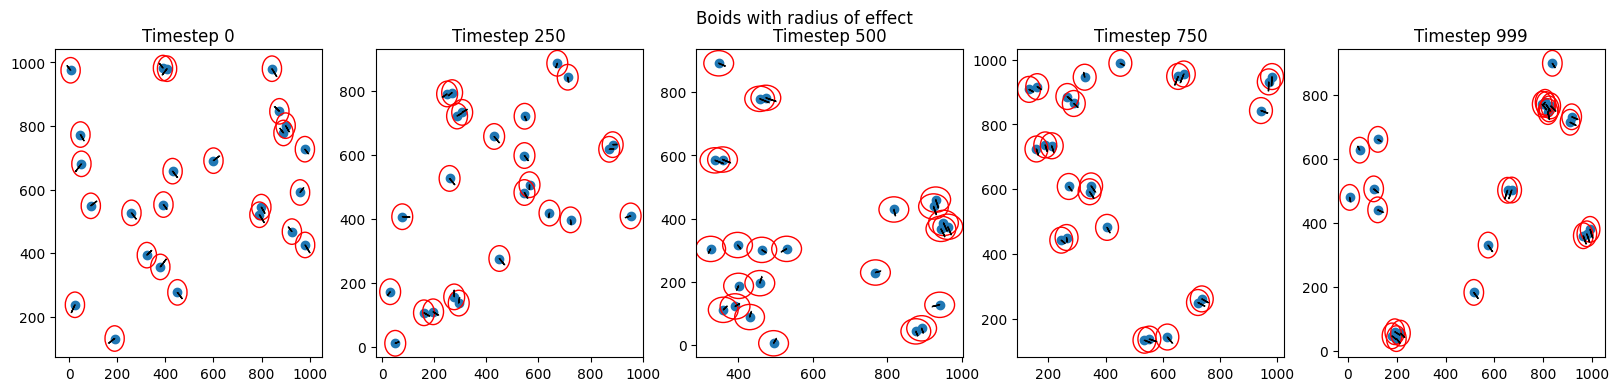

In [24]:
# Plot timesteps 0, 250, 500, 750, 999 for the first trajectory
trajectory = trajectories[0]
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle("Boids with radius of effect")
radius = 40

for i, t in enumerate([0, 250, 500, 750, 999]):
    axs[i].set_title(f"Timestep {t}")
    # Plot dots for the boids
    axs[i].scatter(trajectory[t, :, 0], trajectory[t, :, 1])
    # Draw a red circle around each boid to indicate the radius
    for j in range(trajectory.shape[1]):
        circle = plt.Circle((trajectory[t, j, 0], trajectory[t, j, 1]), radius, color='r', fill=False)
        axs[i].add_artist(circle)
    # plot the boid velocities as arrows
    for j in range(trajectory.shape[1]):
        # NOTE: The arrows are made larger for effect
        axs[i].arrow(trajectory[t, j, 0], trajectory[t, j, 1], trajectory[t, j, 2]*5, trajectory[t, j, 3]*5)
plt.show()

Above, we show the boids with their radius of effect. As expected, boids who are farther than `radius=40` units away from eachother, are shown to not affect eachother. 

## Question 2: Implement your own model

As discussed above, the Boids system is equivariant to
- Permutation
- Translation
- Rotation/Reflection

Your next task is to build a model that is at least* equivariant to permutation and translation. Make sure your model adheres to the PBC, either via the loss function or position updates.

For this you will have to code up:

1. The `InMemoryDataset` used when training your model.
2. The Permutation/Translation Equivariant model `TranslationalEquivariantModel`
3. Possibly a new rollout method `model2_rollouts`
    - HINT: Depending on your design choices, you may need to store the initial coordinates of your nodes.

*: You are of course welcome to build a model that is E(n) equivariant, but this is next week's material `:^)`

In [43]:
from tqdm import trange


class Equivariant_Boids_Dataset(InMemoryDataset):
    def __init__(
        self,
        raw_data_path,
        processed_data_path,
        root=None,
        transform=None,
        pre_transform=None,
        post_transform=None,
        solution_idx_range=(0, 25),
        timesteps=1000,
        processed_file_name="AR1_Boids.pt",
        L=1000,
    ):
        self.raw_data_path = raw_data_path
        self.processed_data_path = processed_data_path
        self.solution_idx_range = solution_idx_range
        self.timesteps = timesteps
        self.processed_file_name = processed_file_name
        self.pre_transform = pre_transform
        self.transform = transform
        self.post_transform = post_transform
        self.L = L
        super(Equivariant_Boids_Dataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def processed_file_names(self):
        return [self.processed_file_name]

    @property
    def raw_file_names(self):
        return [
            pfn
            for pfn in os.listdir(self.raw_data_path)
            if (
                self.solution_idx_range[0]
                <= int(pfn.split("_")[-1][:-4])
                < self.solution_idx_range[1]
            )
        ]

    def download(self):
        pass

    def __len__(self):
        return (self.timesteps - 1) * (
            self.solution_idx_range[1] - self.solution_idx_range[0]
        )

    def process(self):
        """
        Your code goes here.

        Process the raw data and save the processed data to disk, see the AR_Boids_Dataset for an example.

        HINT: Make sure your learning task adheres to the PBC constraints - depending on your approach,
        you may need to include the PBC constraints in the data processing step.
        """

        data_list = []
        for idx, raw_path in enumerate(self.raw_file_names):
            trajectory = np.load(self.raw_data_path + raw_path)

            if self.transform is not None:
                trajectory = self.transform(trajectory)

            for t in range(trajectory.shape[0] - 1):
                x = torch.tensor(trajectory[t], dtype=torch.float)
                y_temp = torch.tensor(trajectory[t + 1], dtype=torch.float)
                # Right now y is (position x, position y, velocity x, velocity y) for the next timestep
                # However, we want delta position and delta velocity
                # Luckily, the delta poisition is just the velocity from the next timestep, and the delta velocity is the acceleration
                # So we can just take the last two elements of y to get the delta velocity
                # First we copy the last two columns of y to the first two columns of y
                y = y_temp.clone()
                y[:, :2] = y_temp[:, 2:]
                # Then we calculate the acceleration
                y[:, 2:] = y_temp[:, 2:] - x[:, 2:]

                edge_index = (
                    torch.tensor(
                        [
                            [i, j]
                            for i in range(trajectory.shape[1])
                            for j in range(trajectory.shape[1])
                            if i != j
                        ],
                        dtype=torch.long,
                    )
                    .t()
                    .contiguous()
                )

                if self.post_transform is not None:
                    data = self.post_transform(data)

                # ---------------- NEW CODE ----------------
                shifted_x = torch.stack(
                    [
                        x[:, :2] + torch.tensor([v_shift, h_shift])
                        for v_shift in [-self.L, 0, self.L]
                        for h_shift in [-self.L, 0, self.L]
                    ]
                )
                min_dists = torch.min(torch.cdist(shifted_x, x[:, :2]), dim=0).values
                edge_attr = (
                    torch.tensor(
                        [
                            [min_dists[i, j]]
                            for i in range(x.shape[0])
                            for j in range(x.shape[0])
                            if i != j
                        ],
                        dtype=torch.float,
                    )
                    .t()
                    .contiguous()
                )
                data = Data(x=x[:, 2:], y=y, edge_index=edge_index, edge_attr=edge_attr)
                # ------------------------------------------
                data_list.append(data)
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_data_path + self.processed_file_name)

    def __getitem__(self, idx):
        return self.get(idx)

    def __repr__(self):
        return f"{self.__class__.__name__}({len(self)})"

In [44]:
equivariant_train_dataset = Equivariant_Boids_Dataset(
    raw_data_path="../data/boids/raw/", 
    processed_data_path="../data/boids/processed/", 
    root="../data/boids/", 
    solution_idx_range=(0, 15), 
    timesteps=1000, 
    processed_file_name="AR1_Boids_Equivariant.pt"
    )

equivariant_validation_dataset = Equivariant_Boids_Dataset(
    raw_data_path="../data/boids/raw/", 
    processed_data_path="../data/boids/processed/", 
    root="../data/boids/", 
    solution_idx_range=(16, 25), 
    timesteps=1000, 
    processed_file_name="AR1_VAL_Boids_Equivariant.pt"
    )


/Users/pelokbal/Uni/Q5/2AMM40/Practicals/atai-2024/venv/lib/python3.11/site-packages/torch_geometric/data/dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

In [46]:
init_positions = torch.load("../data/boids/processed/AR1_Boids_Equivariant.pt")
print(init_positions)
init_val_positions = torch.load("../data/boids/processed/AR1_VAL_Boids_Equivariant.pt")
print(init_val_positions)

(Data(x=[374625, 2], edge_index=[2, 8991000], edge_attr=[14985, 600], y=[374625, 4]), {'x': tensor([     0,     25,     50,  ..., 374575, 374600, 374625]), 'edge_index': tensor([      0,     600,    1200,  ..., 8989800, 8990400, 8991000]), 'edge_attr': tensor([    0,     1,     2,  ..., 14983, 14984, 14985]), 'y': tensor([     0,     25,     50,  ..., 374575, 374600, 374625])})
(Data(x=[224775, 2], edge_index=[2, 5394600], edge_attr=[8991, 600], y=[224775, 4]), {'x': tensor([     0,     25,     50,  ..., 224725, 224750, 224775]), 'edge_index': tensor([      0,     600,    1200,  ..., 5393400, 5394000, 5394600]), 'edge_attr': tensor([   0,    1,    2,  ..., 8989, 8990, 8991]), 'y': tensor([     0,     25,     50,  ..., 224725, 224750, 224775])})


/var/folders/w0/2rh4b4h16zdgh0jjh4zcw_vr0000gn/T/ipykernel_31221/2903684923.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  init_positions = torch.load("../data/boids/pr

In [ ]:
class TranslationalEquivariantModel(torch.nn.Module):
    def __init__(self):
        super(TranslationalEquivariantModel, self).__init__()
        # TODO: TODO: TODO: TODO: TODO:
        """Your code goes here"""
        pass

    def forward(self, data):
        # TODO: TODO: TODO: TODO: TODO:
        """
        Your code goes here
        
        """
        # NOTE: You may use different data attributes instead of x, edge_index, edge_attr
        # But you should pass a Data object to the model 
        # (see the AR_Set_Model for an example and the Trainer class for how this is used)
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        y = None
        return y

In [ ]:
translational_equivariant_model = TranslationalEquivariantModel()
trainer = Trainer(translational_equivariant_model, equivariant_train_dataset, equivariant_validation_dataset, batch_size=8, loss_fn=torch.nn.MSELoss(), epochs=100, model_name="02-Translational-Equivariant-Model.pt")
trainer.train_loop()

In [ ]:
def model2_rollouts(model, dataset, positions_dataset, timesteps=1000, device='cuda', mode="residual", width = 1000, height = 1000):
    """
    Predict the rollouts of the model on the dataset starting from the idx

    Args:
        model: PyTorch model
        dataset: PyTorch dataset
        timesteps: Number of timesteps to predict
        device: Device to run the model on
        mode: "residual" or "direct"
        - In the solution above, we used the "residual" mode, where the model predicts the change in position and velocity
        - In the "direct" mode, the model predicts the position and velocity directly (if you do not intend to use this mode, you can ignore this argument)
        width: Width of the PBC box
        height: Height of the PBC box
    Returns:
        rollouts: Rollouts of the model on the dataset
        - Should be a torch tensor of shape (Batch, Timesteps, Boids, Node_dim)
    """
    rollouts = torch.empty((len(dataset), timesteps, dataset[0].x.shape[0], dataset[0].x.shape[1]), device=device)
    print(rollouts.shape)

    # ~ ^ ~ ^ ~ ^ ~ ^ ~ ^ ~ ^
    #     Your code here
    # ~ ^ ~ ^ ~ ^ ~ ^ ~ ^ ~ ^

    
    return rollouts

In [ ]:
initial_states_validation_dataset = AR_Boids_Dataset(
    raw_data_path="../data/boids/raw/", 
    processed_data_path="../data/boids/processed/", 
    root="../data/boids/", 
    solution_idx_range=(16, 25), 
    timesteps=2, 
    processed_file_name="AR1_VAL_Equivariant_init.pt",
    transform=keep_01
    )

print(initial_states_validation_dataset[1])

translational_equivariant_model_rollout = model2_rollouts(model, initial_states_validation_dataset, init_val_positions.to(device), timesteps=1000, device=device)

Above, we show the boids with their radius of effect. As expected, boids who are farther than `radius=40` units away from eachother, are shown to not affect eachother. 

So in our dataset, we form undirected edges between nodes with a max PBC distance of 40 units.

## E(n) Equivariant Graph Neural Networks
In Satorras, Hoogeboom, Welling's paper [3] with the same name, they introduce a relatively simple model that is equivariant to E(n) transformations. Next lecture will be on how their framework works, and next practical we will implement it from scratch. 

If you have too much time on your hands, give their [paper](https://arxiv.org/pdf/2102.09844) [3] a read, and check out their [implementation](https://github.com/vgsatorras/egnn)

## Evaluating scientific AI models

The Boids simulations are very sensitive to changes in the initial state. Slight changes in the initial state can lead to drastically different final states. Similarly, emulations (the neural network predictions) can accumulate errors very quickly.

Using MSE to compare models to the ground truth or to eachother here does not account for this error accumulation. As a result, a likely generated/predicted trajectory can have high MSE.

Luckily for us, there are usually better ways to evaluate models! When working in an interdisciplinary group, the physics wizards will propose a metric that should hold true even when trajectories diverge, or our predictions suffer from accumulating errors.

In the Boids setting, we can investigate the distribution of velocities, since these should (hopefully) remain invariant even under diverging trajectories / error accumulation.

If we plot them visually, we want to investigate how different the predicted velocity distributions are from the ground truth velocity distributions. However, since we have to investigate the distributions for each timestep, let's use the Kullback-Leibler Divergence ($D_\text{KL}$) metric to measure the difference. For two distributions $P$ and $Q$, it is defined as follows:


$D_\text{KL}(P||Q) = \int p(x) \ln \frac{p(x)}{q(x)} \text{d} x $


![KL Divergence](https://hugocisneros.com/ox-hugo/forwardvsreversedKL.jpg)


The $D_\text{KL}$ between two distributions $P$ and $Q$ is asymmetric, meaning $D_\text{KL}(P||Q) \neq D_\text{KL}(Q||P)$, as illustrated above. 

Since we care more whether the predicted distribution $Q$ fits under the ground truth distribution $P$, we will use the reverse KL: $D_\text{KL}(Q||P)$

In [ ]:
def compare_distributions(dist1, dist2):
    """
    Compare two distributions by computing the KL divergence

    Args:
        dist1: torch.distributions.Distribution
        dist2: torch.distributions.Distribution
    """
    kl = torch.distributions.kl_divergence(dist1, dist2)
    return kl

def compute_distribution_per_timestep(data, timesteps):
    """
    Compute the distribution of the data per timestep

    Args:
        data: torch.Tensor of shape (T, N, 4)
        timesteps: int, number of timesteps to compute the distribution for

    Returns:
        list of torch.distributions.Normal
    """
    distributions = []
    for t in range(timesteps):
        # Compute the mean and std of the data
        mean = data[:, t, :, :].mean()
        std = data[:, t, :, :].std()
        dist = torch.distributions.Normal(mean, std)
        distributions.append(dist)
    return distributions

def compute_mean_kl_divergence(data, distributions):
    """
    Compute the mean KL divergence between the data and the distributions

    Args:
        data: torch.Tensor of shape (T, N, 4)
        distributions: list of torch.distributions.Normal

    Returns:
        float
    """
    kl_divergences = []
    for t in range(data.shape[0]):
        kl = compare_distributions(distributions[t], data[t, :, :])
        kl_divergences.append(kl)
    return torch.tensor(kl_divergences).mean()

def plot_kl_divergence(distributions1, distributions2, title="KL Divergence between <distributions1> and <distributions2>"):
    """
    Plot the KL divergence between the data and the distributions

    Args:
        distributions1: list of torch.distributions.Normal
        distributions2: list of torch.distributions.Normal
    """
    kl_divergences = []
    for t in range(len(distributions1)):
        kl = compare_distributions(distributions1[t], distributions2[t]).cpu().numpy()
        kl_divergences.append(kl)


    plt.plot(kl_divergences)
    plt.xlabel("Timestep")
    plt.ylabel("KL Divergence")
    plt.title(title)
    plt.show()

In [ ]:
validation_files = [pfn for pfn in os.listdir("../data/boids/raw/") if (16 <= int(pfn.split("_")[-1][:-4]) < 25)]
validation_trajectories = [np.load("../data/boids/raw/" + f) for f in validation_files]
validation_trajectories = torch.tensor(validation_trajectories, dtype=torch.float)

dists_GT = compute_distribution_per_timestep(validation_trajectories[:,:,:,2:], 1000)
dists_AR_set = compute_distribution_per_timestep(ar_set_model_rollout[:,:,:,2:], 1000)
plot_kl_divergence(dists_AR_set, dists_GT, title="KL Divergence between AR Set Model velocities and the GT velocities per timestep")



In [ ]:
dists_equivariant = compute_distribution_per_timestep(translational_equivariant_model_rollout, 1000)
plot_kl_divergence(dists_equivariant, dists_GT, title="KL Divergence between Translational Equivariant Model velocities and the GT velocities per timestep")

## Question 3:
Now that we have some plots for both models, provide some comparison between the two.

3a. What can you infer from these KL divergence plots?

3b. What would you improve in this evaluation routine?
- HINT: What assumptions do we make when computing the distributions (in `compute_distributions_per_timestep`)?

### Next week's content
Next week, in addition to going over E(n) equivariant models, we will explore another method for evaluating scientific AI model - with _sensitivity analysis_.

# References

[1] Minartz, K., Poels, Y., Koop, S., & Menkovski, V. (2023). Equivariant Neural Simulators for Stochastic Spatiotemporal Dynamics. https://openreview.net/forum?id=CCVsGbhFdj

[2] Reynolds, C. W. (1987) Flocks, Herds, and Schools: A Distributed Behavioral Model, in Computer Graphics, 21(4) (SIGGRAPH '87 Conference Proceedings) pages 25-34.

[3] Satorras, V. G., Hoogeboom, E., & Welling, M. (2021, July). E (n) equivariant graph neural networks. In International conference on machine learning (pp. 9323-9332). PMLR.